In [3]:
!pip install --user -U nltk
!pip install scikit-learn==0.23.1
!pip install numpy
!pip install pandas
!pip install tensorflow
!pip install keras
!nltk.download('vader_lexicon')

zsh:1: unknown file attribute: v


In [1]:
import numpy as np
import pandas as pd
import json
import nltk
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, LSTM, Dropout, Dense
from tensorflow.keras.layers import SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical

#Regular Expression
import re

import tensorflow as tf
tf.compat.v1.reset_default_graph()

In [2]:
with open("../data/reviewSelected100.json", 'r', encoding="ISO-8859-1") as read_file:
    data = [json.loads(line) for line in read_file]

In [3]:
#Store all reviews in a Pandas DataFrame 
reviews = []
for rev in range(len(data)):
    reviews.append(data[rev]['text'])
    
rev_df = pd.DataFrame(reviews, columns = ['Reviews'])
rev_df.head()

,Reviews
0,We had my Mother's Birthday Party here on 10/2...
1,Good Korean grill near Eaton Centre. The marin...
2,Was recommended to try this place by few peopl...
3,Ambience: Would not expect something this nice...
4,Absolutely the WORST pool company that I have ...


In [4]:
#Clean data 
import re

#1. Removes Punctuations
def remove_punctuations(data):
    punct_tag=re.compile(r'[^\w\s]')
    data=punct_tag.sub(r'',data)
    return data

#2. Removes HTML syntaxesn(if reviews provide business links)
def remove_html(data):
    html_tag=re.compile(r'<.*?>')
    data=html_tag.sub(r'',data)
    return data

#3. Removes URL data (if reviews provide business links)
def remove_url(data):
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

#4. Removes Emojis (if reviews contains expressions)
def remove_emoji(data):
    emoji_clean= re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    data=emoji_clean.sub(r'',data)
    url_clean= re.compile(r"https://\S+|www\.\S+")
    data=url_clean.sub(r'',data)
    return data

#5. Lemmatize
def lemma_train(data):
    lemmatizer=WordNetLemmatizer()
    out_data=""
    for words in data:
        out_data+= lemmatizer.lemmatize(words)
    return out_data

rev_df['Reviews']=rev_df['Reviews'].apply(lambda z: remove_punctuations(z))
rev_df['Reviews']=rev_df['Reviews'].apply(lambda z: remove_html(z))
rev_df['Reviews']=rev_df['Reviews'].apply(lambda z: remove_url(z))
rev_df['Reviews']=rev_df['Reviews'].apply(lambda z: remove_emoji(z))
rev_df['Reviews']=rev_df['Reviews'].apply(lambda z: lemma_train(z))

In [5]:
rev_df_clean = rev_df
rev_df_clean.head()

,Reviews
0,We had my Mothers Birthday Party here on 10291...
1,Good Korean grill near Eaton Centre The marina...
2,Was recommended to try this place by few peopl...
3,Ambience Would not expect something this nice ...
4,Absolutely the WORST pool company that I have ...


In [6]:
#Feature Engineering 

'''
Separate the reviews into positive and negative using nltk sentiment vader
'''
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk_sent = SentimentIntensityAnalyzer()

rev_df_clean['ratings'] = rev_df_clean["Reviews"].apply(lambda x: nltk_sent.polarity_scores(x))
rev_df_new = pd.concat([rev_df_clean.drop(['ratings'], axis=1), rev_df_clean['ratings'].apply(pd.Series)], axis=1)

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/esther/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [7]:
rev_df_new['comp_rating'] = rev_df_new['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

rev_df_new.head()

,Reviews,neg,neu,pos,compound,comp_rating
0,We had my Mothers Birthday Party here on 10291...,0.000,0.592,0.408,0.9300,pos
1,Good Korean grill near Eaton Centre The marina...,0.055,0.736,0.208,0.9448,pos
2,Was recommended to try this place by few peopl...,0.006,0.687,0.307,0.9975,pos
3,Ambience Would not expect something this nice ...,0.094,0.759,0.148,0.8318,pos
4,Absolutely the WORST pool company that I have ...,0.090,0.885,0.026,-0.9402,neg


In [8]:
upd_df = rev_df_new.drop(columns=['neg','neu','pos','compound'])

In [9]:
sentiment_label = upd_df["comp_rating"].factorize()
sentiment_label

(array([0, 0, 0, ..., 0, 0, 0]), Index(['pos', 'neg'], dtype='object'))

In [10]:
text_data = upd_df["Reviews"]

#Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_data)
encoded_text_data = tokenizer.texts_to_sequences(text_data)

In [11]:
SEQUENCE_LENGTH = 200
EMBEDDING_SIZE = 32
TEST_SIZE = 0.25
BATCH_SIZE = 32
EPOCHS = 5

In [12]:
#ensure all sentences are same size 
padded_text_data = pad_sequences(encoded_text_data, maxlen=200)

In [13]:
#Early stopping 
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode = 'min')

In [14]:
model = Sequential()
model.add(Embedding(len(tokenizer.word_index)+1,
          EMBEDDING_SIZE,
          input_length=SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.2))
model.add(Dropout(0.3))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer="adam", loss='binary_crossentropy',
              metrics=["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 32)           1140800   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               82432     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 1,223,361
Trainable params: 1,223,361
Non-trainable params: 0
_________________________________________________________________


In [15]:
history = model.fit(padded_text_data,sentiment_label[0],validation_split=0.2,epochs=EPOCHS,batch_size=BATCH_SIZE, callbacks=[early_stopping])

Epoch 1/5
383/383 [==============================] - 104s 272ms/step - loss: 0.3715 - accuracy: 0.8571 - val_loss: 0.3007 - val_accuracy: 0.8807
Epoch 2/5
383/383 [==============================] - 100s 260ms/step - loss: 0.2345 - accuracy: 0.9027 - val_loss: 0.2608 - val_accuracy: 0.8843
Epoch 3/5
383/383 [==============================] - 99s 259ms/step - loss: 0.1832 - accuracy: 0.9274 - val_loss: 0.2687 - val_accuracy: 0.8827


In [16]:
#Mean accuracy 
mean_acc = np.mean(history.history['val_accuracy'])
print("Mean Accuracy: "+ str(mean_acc*100) +"%")

Mean Accuracy: 88.25708031654358%


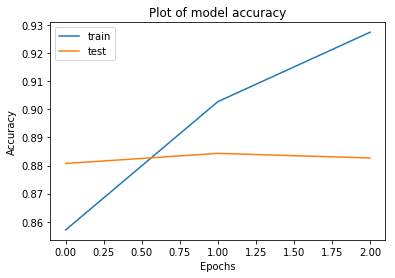

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='train') 
plt.plot(history.history['val_accuracy'], label='test') 
plt.title("Plot of model accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

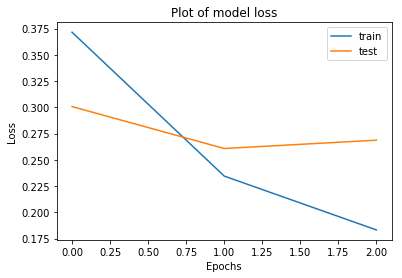

In [18]:
plt.plot(history.history['loss'], label='train') 
plt.plot(history.history['val_loss'], label='test') 
plt.title("Plot of model loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [19]:
#Get text predictions
def get_predictions(text):
    sequence = tokenizer.texts_to_sequences([text])
    # pad the sequence
    sequence = pad_sequences(sequence, maxlen=200)
    prediction = int(model.predict(sequence).round().item())
    print("Predicted Label:", sentiment_label[1][prediction])

In [20]:
rev_text = "I ordered this chair last week. The condition was really good. The support is comfortable for the back and the seat is strong"

In [21]:
get_predictions(rev_text)

Predicted Label: pos


In [22]:
neg_rev = "Never again! The service was so slow and the food was not good."
get_predictions(neg_rev)

Predicted Label: neg


#### Testing Model Performance

Sample 20 reviews from the Yelp Dataset and apply the model in

In [23]:
sample_df = upd_df["Reviews"].sample(n=20)
sample_df

8801     The hotel service was outstanding and we reall...
3267     Very impressed with our experience at Mayworth...
5015     I come here for one thing\n\n\nThe grilled chi...
5316     In a half empty restaurant we were told that e...
2761     Good home made style burger Dont be alarmed by...
5326     Awesome mom and pop shop Recommend to me by my...
6064     Yummy eat em ups thanks hot food great people ...
9679     So I have had a hatehate relationship with Big...
3908     This place is utterly disturbing The fact that...
6518     Was excited to try this place based on reviews...
13189    I love it here yet hate to come if that makes ...
11252    This was my wifes  I first time doing a detoxi...
8976     Let me start off by saying that they just lost...
12014    We just bought a new Mazda 6 and had a very fa...
10159    Came get after a futsal tournament at nearby l...
6062     Loving this place I came across by chance a fe...
2589     I love this place This is one of the very few .

In [24]:
for i in range(len(sample_df)):
    print(sample_df.values[i])
    get_predictions(sample_df.values[i])
    print("Actual Label: " + str(upd_df['comp_rating'][sample_df.index[i]]))
    print("-----------")

The hotel service was outstanding and we really enjoyed our experience  It is a unique property that was a bank that was converted to a hotel  We really enjoyed our dinner in the restaurant and the fitness center is well equipped I would definitely suggest checking out the bank vault in the basement that has been converted to a cocktail lounge  The property also is dog friendly
Predicted Label: pos
Actual Label: pos
-----------
Very impressed with our experience at Mayworth Public House Courteous service delicious food and solid prices Any place my wife can get fish tacos and I can get a burger is a winner Everything came just as we ordered it and we both enjoyed a piece of delicious cheesecake for dessert for 599 Cool that they have a brunch menu as well Well definitely be back for a second go around
Predicted Label: pos
Actual Label: pos
-----------
I come here for one thing


The grilled chicken chimichangas with the red sauce on the side so i can use it for dipping  I cannot tell y